In [1]:
import scipy.io
import mne
import os
import numpy as np

mne.set_log_level('error')


In [2]:
data_root = 'C:/Data/UHD_EEG/'
subjects = ['S1', 'S2', 'S3', 'S4', 'S5']
dominant_hand = ['left','right','right','right','right']
mapping = {0: "No instruction", 1: "Rest", 2: "thumb", 3: "index", 4: "middle", 5: "ring", 6: "little"}


In [3]:
def get_montage(hemishpere):
    mat = scipy.io.loadmat(os.path.join(data_root, 'montage', f'montage_256_{hemishpere}_hemisphere.mat'))
    return mat['pos_256']

left_handed_montage = get_montage('right')
right_handed_montage = get_montage('left')

In [4]:
def load(subject_id, run):
    # LOAD DATA
    subject = subjects[subject_id]
    mat = scipy.io.loadmat(os.path.join(data_root, 'rawdata', subject, subject + '_run' + str(run) + '.mat'))
    data = mat['y']
    data = data[1:] # remove timestamp
    ch_names = ['c' + str(i) for i in range(1, 257)]
    ch_names.append('STIM')
    info = mne.create_info(ch_names = ch_names, sfreq=mat['SR\x00'][0][0]) #, ch_types='eeg')
    raw = mne.io.RawArray(data, info)

    # SET CHANNEL TYPES
    for ch in info.ch_names:
        if ch != 'STIM':
            raw.set_channel_types({ch: 'eeg'})
        else:
            raw.set_channel_types({ch: 'stim'})

    events = mne.find_events(raw, stim_channel='STIM')
    annot_from_events = mne.annotations_from_events(events, event_desc=mapping, sfreq=raw.info['sfreq'])
    raw.set_annotations(annot_from_events)
    raw.drop_channels(['STIM'])


    # SET MONTAGE
    if dominant_hand[subject_id] == 'left':
        montage = left_handed_montage
    else:
        montage = right_handed_montage

    montage = mne.channels.make_dig_montage(ch_pos=dict(zip(ch_names, montage)), coord_frame='head')
    raw.set_montage(montage)


    raw.describe()
    return raw

In [5]:
demo = load(0, 1)

<RawArray | 256 x 135559 (225.9 s), ~265.0 MB, data loaded>
 ch  name  type  unit        min         Q1     median         Q3        max
  0  c1    EEG   µV    -85493210937.50  -35441191406.25  1677024414.06  36613792968.75  81199593750.00
  1  c2    EEG   µV    -85721015625.00  -35531160156.25  1664257812.50  36644519531.25  81226898437.50
  2  c3    EEG   µV    -85876343750.00  -35615492187.50  1649694213.87  36730896484.38  81483765625.00
  3  c4    EEG   µV    -85769679687.50  -35548326171.88  1663018066.41  36666996093.75  81330179687.50
  4  c5    EEG   µV    -85758578125.00  -35550046875.00  1659248779.30  36668800781.25  81367742187.50
  5  c6    EEG   µV    -85414617187.50  -35385037109.38  1647537475.59  36503046875.00  80972781250.00
  6  c7    EEG   µV    -85671015625.00  -35482373046.88  1650583496.09  36601558593.75  81176257812.50
  7  c8    EEG   µV    -85453140625.00  -35408878906.25  1628080566.41  36478734375.00  80898117187.50
  8  c9    EEG   µV    -85142101562.50 

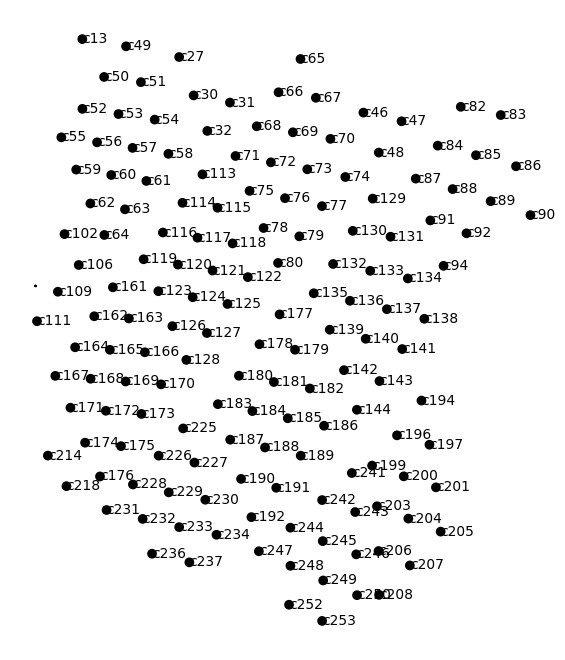

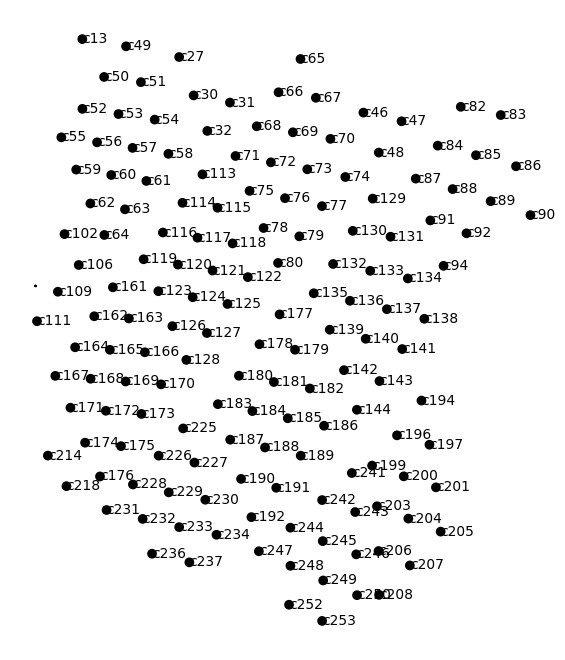

In [54]:
demo.plot_sensors(show_names=True)

In [55]:
droped = demo.copy().pick_channels(out_names)

ValueError: No channels match the selection.

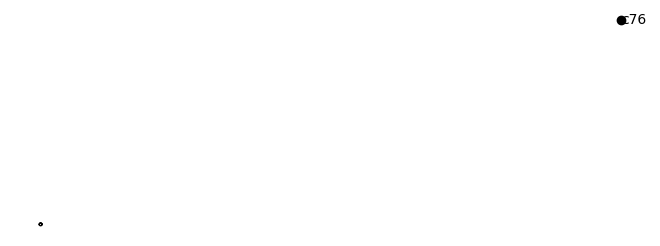

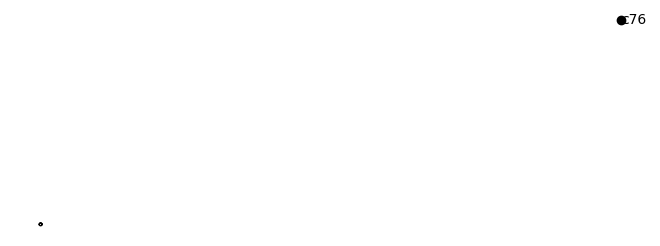

In [101]:
bad_channels =['c65', 'c66', 'c67', 'c68', 'c69', 'c70', 'c71', 'c72', 'c73', 'c74', 'c75', 'c76', 'c77', 'c78', 'c79', 'c80']
bad = demo.copy().pick_channels(bad_channels)
bad.plot_sensors(show_names=True)

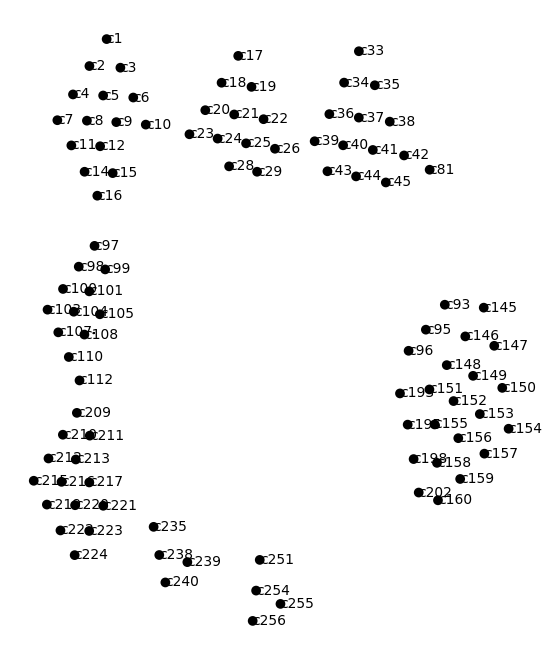

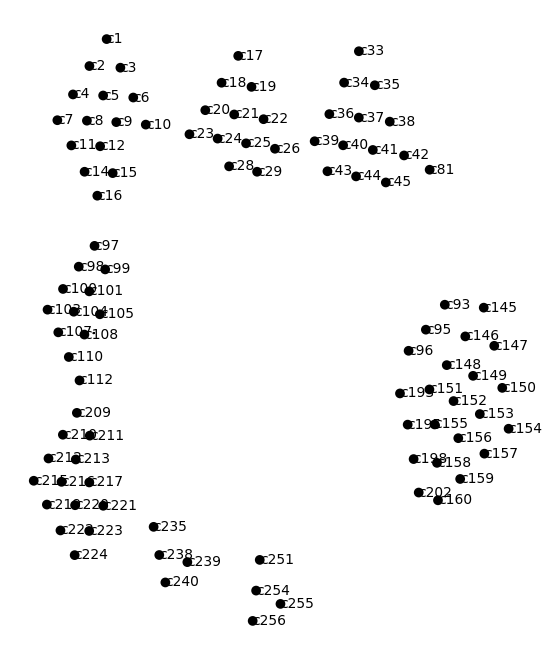

In [ ]:
droped.plot_sensors(show_names=True)

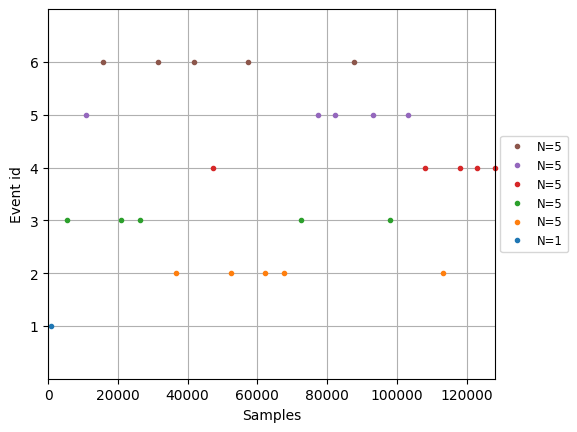

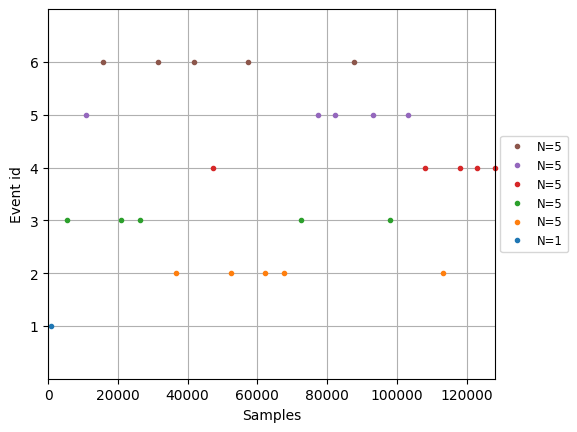

In [94]:
events, event_ids = mne.events_from_annotations(demo)
mne.viz.plot_events(events)

In [95]:
demo.filter(13., 25.)
demo.set_eeg_reference('average', projection=False)

my_ids = [115,127,182,140,130,76,113]
filt = ['c' + str(i) for i in my_ids]
demo.pick_channels(filt)

<RawArray | 7 x 135559 (225.9 s), ~7.3 MB, data loaded>

In [96]:
epochs = mne.Epochs(demo, events, baseline = None, event_id= event_ids, tmin=-0.5, tmax=7, preload=True)


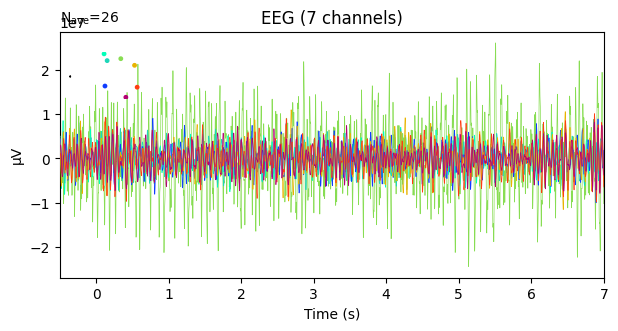

In [97]:
epochs.average().plot(spatial_colors=True);

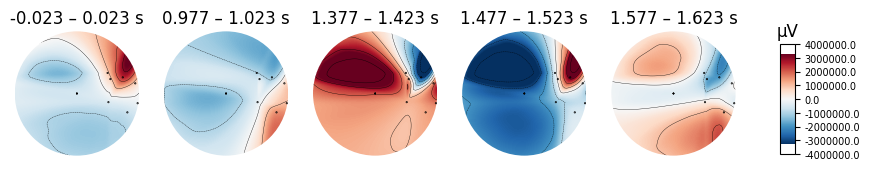

In [102]:
# Specify times to plot at, as [min],[max],[stepsize]
times = [0, 1., 1.4, 1.5, 1.6]

epochs.average().plot_topomap(times=times, average=0.050);

In [103]:
conditions = ['ring', 'middle']

evokeds = {c:epochs[c].average() for c in conditions}
for key in evokeds.keys():
  print(key,'-->',evokeds[key])  

ring --> <Evoked | 'ring' (average, N=5), -0.5 – 7 sec, baseline off, 7 ch, ~353 kB>
middle --> <Evoked | 'middle' (average, N=5), -0.5 – 7 sec, baseline off, 7 ch, ~353 kB>


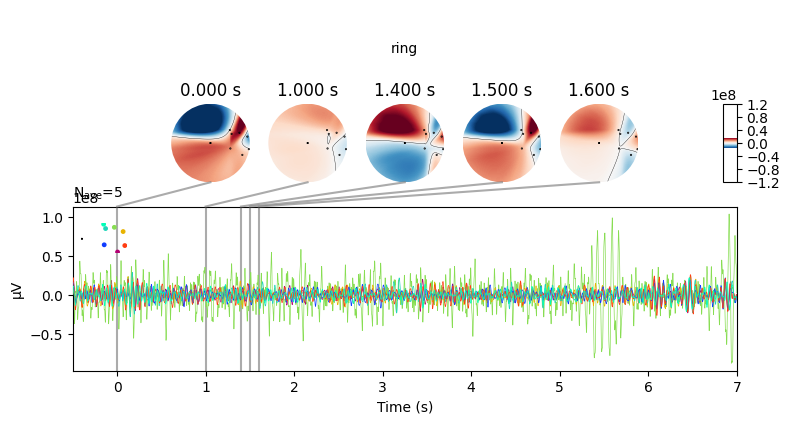

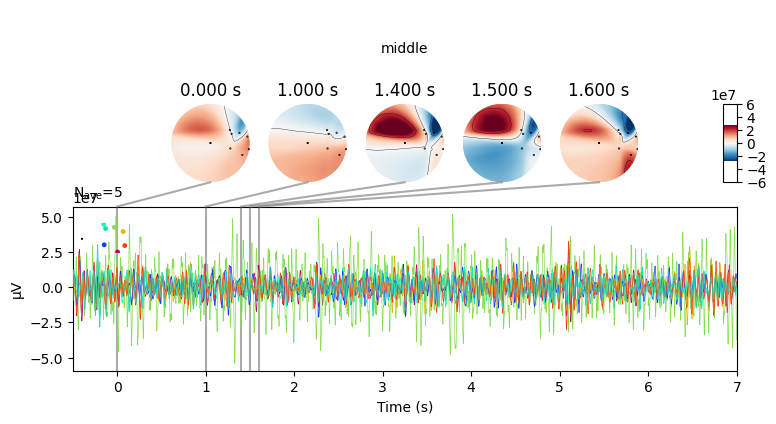

In [104]:
for c in evokeds.keys():
    evokeds[c].plot_joint(times=times, title=c);